# 합성곱 신경망을 사용하여 CIRAR-10 dataset 분류

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.1  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


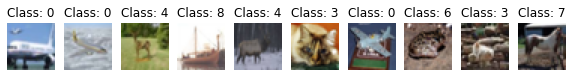

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

- CNN 모델 설계하기
  - [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2ed), [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d) 활용한 CNN 모델 구성
  - `nn.Conv2d` : 2차원의 필터를 사용한 convolution 연산 수행
    - `in_channels` : Input 값들의 Channel 수 (최초의 경우 RGB 3 channels, 이후에는 Feature map의 channel 수)
    - `out_channels` : 사용할 Filter의 수
    - `kernel_size` : Filter의 크기 (int or tuple)
    - `padding` : zero padding을 input의 네 면에 몇 층으로 쌓을 것인지에 대한 값
      - `1`이면, 네 면에 한 개의 층을 둘러 쌓는다는 의미

    - Input의 Shape
      - (N, C, H, W)
        - N: Batch size
        - C: Channel 수
        - H, W : Image 혹은 Feature map의 Height, Width

  - `nn.MaxPool2d` : 2차원 공간에서의 Max-pooling 수행

In [7]:
''' 6. Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(4 * 4 * 32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.mish(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.mish(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.mish(x)
        x = self.pool(x)
        
        x = x.view(-1, 4 * 4 * 32)
        x = self.fc1(x)
        x = F.mish(x)
        x = self.fc2(x)
        x = F.mish(x)
        x = self.fc3(x)
        # x = F.log_softmax(x)
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
''' 10. CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.306007
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.904280
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.644872
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.709284
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.840519
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.600268
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.153087
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.622708

[EPOCH: 1], 	Test Loss: 0.0424, 	Test Accuracy: 51.11 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.081186
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.331098
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.317685
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.247629
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.929557
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.178364
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.560368
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.231769

[EPOCH: 2], 	Test Loss: 0.0384, 	Test Accuracy: 55.91 % 